In [1]:
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [2]:
import os
import ssl

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
pip install numpy

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-image matplotlib seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [9]:
# Aggressive augmentation for training using ResNet50's preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

In [10]:
# For validation and testing, only apply preprocessing
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
# Create generators; updating target_size to 224x224 for ResNet50
train_generator = train_datagen.flow_from_directory(
    "chest_xray/chest_xray/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [12]:
valid_generator = valid_datagen.flow_from_directory(
    "chest_xray/chest_xray/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 16 images belonging to 2 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Found 624 images belonging to 2 classes.


Model Building using ResNet50

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [15]:
# Load ResNet50 with pre-trained ImageNet weights, without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step


In [16]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [17]:
# Add custom layers on top for our two-class problem
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)


In [18]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
from tensorflow.keras.optimizers import Adam

# Corrected optimizer instantiation
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 75,034,370 (286.23 MB)

 Trainable params: 51,446,658 (196.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Callbacks for Training
# ---------------------------
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
cp = ModelCheckpoint('resnet50_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ---------------------------

In [22]:
# Model Training
# ---------------------------
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20,
    callbacks=[es, cp, lrr]
)

# ---------------------------

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8135 - loss: 1.4725
Epoch 1: val_loss improved from inf to 0.23573, saving model to resnet50_best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.8137 - loss: 1.4703 - val_accuracy: 0.8750 - val_loss: 0.2357 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8904 - loss: 0.5351
Epoch 2: val_loss improved from 0.23573 to 0.23395, saving model to resnet50_best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.8904 - loss: 0.5348 - val_accuracy: 0.9375 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8984 - loss: 0.3209
Epoch 3: val_loss did not improve from 0.23395
163/163 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.8984 - loss: 0.3207 - val_accuracy: 0.9375 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9056 - loss: 0.2352
Epoch 4: val_loss improved from 0.23395 to 0.21239, saving model to resnet50_best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9056 - loss: 0.2352 - val_accuracy: 0.9375 - val_loss: 0.2124 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9220 - loss: 0.1972
Epoch 5: val_loss did not improve from 0.21239

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9219 - loss: 0.1973 - val_accuracy: 0.8750 - val_loss: 0.2536 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9177 - loss: 0.2013
Epoch 6: val_loss did not improve from 0.21239
163/163 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9178 - loss: 0.2012 - val_accuracy: 0.8750 - val_loss: 0.3372 - learning_rate: 5.0000e-05
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9163 - loss: 0.1983
Epoch 7: val_loss did not improve from 0.21239
163/163 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9163 - loss: 0.1982 - val_accurac

In [23]:
# Model Evaluation
# ---------------------------
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9094 - loss: 0.2708
Test Loss: 0.2426367998123169
Test Accuracy: 0.8990384340286255


In [25]:
pip install scikit-learn


     |████████████████████████████████| 11.1 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Predictions and Evaluation Metrics
# ---------------------------
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score


In [27]:
# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


In [28]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[211  23]
 [ 40 350]]


In [29]:
# Classification Report
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.84      0.90      0.87       234
   PNEUMONIA       0.94      0.90      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.89       624
weighted avg       0.90      0.90      0.90       624



In [30]:
# Compute weighted F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("Weighted F1 Score:", f1)

Weighted F1 Score: 0.8996831552066584


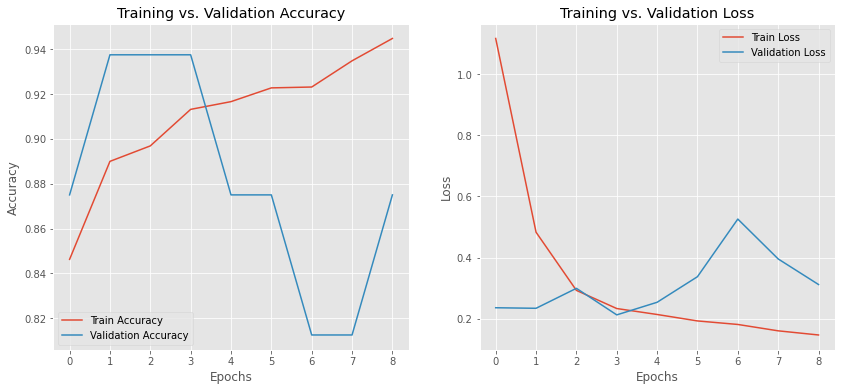

In [31]:
# ---------------------------
# Plotting Training Curves
# ---------------------------
plt.figure(figsize=(14,6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.show()

In [32]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9094 - loss: 0.2708
Test Accuracy: 89.90%


In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [34]:
# Get true labels
y_true = test_generator.classes

# Get predicted probabilities (for class 1)
y_pred_prob = model.predict(test_generator, verbose=1)[:, 1]


20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


In [35]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)


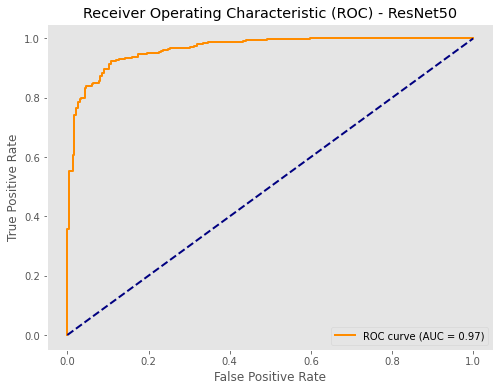

In [36]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - ResNet50')
plt.legend(loc="lower right")
plt.grid()
plt.show()
